# OpenAI gym frozenlake

In [2]:
import gym

In [3]:
from collections import defaultdict

In [4]:
from tqdm import tqdm

In [5]:
import random

In [6]:
import matplotlib.pyplot as plt

In [7]:
import numpy as np

In [8]:
N_GAMES = 100

In [9]:
env = gym.make('MountainCar-v0')

In [10]:
def discretize_state(s_cont, env):
    
    s_disc = (s_cont - env.observation_space.low)*np.array([10, 100])
    s_disc = np.round(s_disc, 0).astype(int)
    
    return s_disc
    

In [11]:
def choose_action_greedy(q_table, obs, env):
    
    return np.argmax(q_table[obs[0], obs[1]])

In [12]:
def choose_action_eps(q_table, obs, env, eps):
    
    # q_table[obs, a]
    
    if random.random() < eps:
        return env.action_space.sample()
    else:
        return choose_action_greedy(q_table, obs, env)

In [13]:
def test_game(env, q_table, n_games=N_GAMES):
    
    total_reward = 0.0
    
    for _ in range(n_games):

        done = False
        obs = env.reset()

        while not done:
            # Choose an action greedily
            new_obs, reward, done, info = env.step(choose_action_greedy(q_table, discretize_state(obs, env), env))
            total_reward += reward
            
            obs = new_obs

    return total_reward/n_games


In [14]:
def q_learning(q_table, obs, action, reward, new_obs, lr, gamma):
    """
    lr : float
        Learning rate
    gamma : float
        Discount factor for future rewards
    """
    
    # TD(0) learning

    # Update entry using bellman's equation

    target = reward + gamma * np.max(q_table[new_obs[0], new_obs[1]])
    q_error = target - q_table[obs[0], obs[1], action]
    q_table[obs[0], obs[1], action] += lr * q_error

In [15]:
EPS_DECAY = 0.99993
GAMMA = 0.99
LR = 0.2

EVALUATE_EVERY = 100

In [19]:
def training(env, q_table, n_episodes, eps, q_history, eps_decay=EPS_DECAY, evaluate_every=EVALUATE_EVERY):
    
    mean_rewards = list()
    
    total_reward = 0
    
    for i in range(n_episodes):
        done = False

        obs = env.reset()
        obs_d = discretize_state(obs, env)

        while not done:
            # Choose an action epsilon-greedily
            action = choose_action_eps(q_table, obs_d, env, eps)

            new_obs, reward, done, info = env.step(action)
            new_obs_d = discretize_state(new_obs, env)
            
            total_reward += reward
            
            q_learning(q_table, obs_d, action, reward, new_obs_d, LR, GAMMA)
            obs_d = new_obs_d

#         eps *= eps_decay
        eps -= eps_decay

        # Evaluate policy every N games
        if (i+1)%evaluate_every == 0:

#             test_reward = test_game(env, q_table)
#             print(f'\tEp: {i+1}  Average reward: {total_reward/evaluate_every} Test reward: {test_reward} {eps:.2f}')
                
            print(f'\tEp: {i+1}  Average reward: {total_reward/evaluate_every} eps: {eps:.2f}')
            
            mean_rewards.append(total_reward/evaluate_every)
    
            total_reward = 0
        
            q_history[(i+1)] = q_table.copy()

#             mean_rewards.append(test_reward)
            
            
    return mean_rewards

In [20]:
# Main learning loop

N_EPISODES = 5000

eps = 1.0

# q_table = defaultdict(float)

# Determine size of discretized state space
num_states = (env.observation_space.high - env.observation_space.low)*\
                np.array([10, 100])
num_states = np.round(num_states, 0).astype(int) + 1


# Initialize Q table
q_table = np.random.uniform(low = -1, high = 1, 
                      size = (num_states[0], num_states[1], 
                              env.action_space.n))

# Save n of actions
n_actions = env.action_space.n

q_history = dict()

mean_rewards = training(env, q_table, N_EPISODES, eps, q_history, eps_decay=eps/N_EPISODES)

	Ep: 100  Average reward: -200.0 eps: 0.98
	Ep: 200  Average reward: -200.0 eps: 0.96
	Ep: 300  Average reward: -200.0 eps: 0.94
	Ep: 400  Average reward: -200.0 eps: 0.92
	Ep: 500  Average reward: -200.0 eps: 0.90
	Ep: 600  Average reward: -200.0 eps: 0.88
	Ep: 700  Average reward: -200.0 eps: 0.86
	Ep: 800  Average reward: -200.0 eps: 0.84
	Ep: 900  Average reward: -200.0 eps: 0.82
	Ep: 1000  Average reward: -200.0 eps: 0.80
	Ep: 1100  Average reward: -200.0 eps: 0.78
	Ep: 1200  Average reward: -200.0 eps: 0.76
	Ep: 1300  Average reward: -200.0 eps: 0.74
	Ep: 1400  Average reward: -200.0 eps: 0.72
	Ep: 1500  Average reward: -200.0 eps: 0.70
	Ep: 1600  Average reward: -200.0 eps: 0.68
	Ep: 1700  Average reward: -200.0 eps: 0.66
	Ep: 1800  Average reward: -200.0 eps: 0.64
	Ep: 1900  Average reward: -200.0 eps: 0.62
	Ep: 2000  Average reward: -200.0 eps: 0.60
	Ep: 2100  Average reward: -200.0 eps: 0.58
	Ep: 2200  Average reward: -200.0 eps: 0.56
	Ep: 2300  Average reward: -200.0 eps: 0.

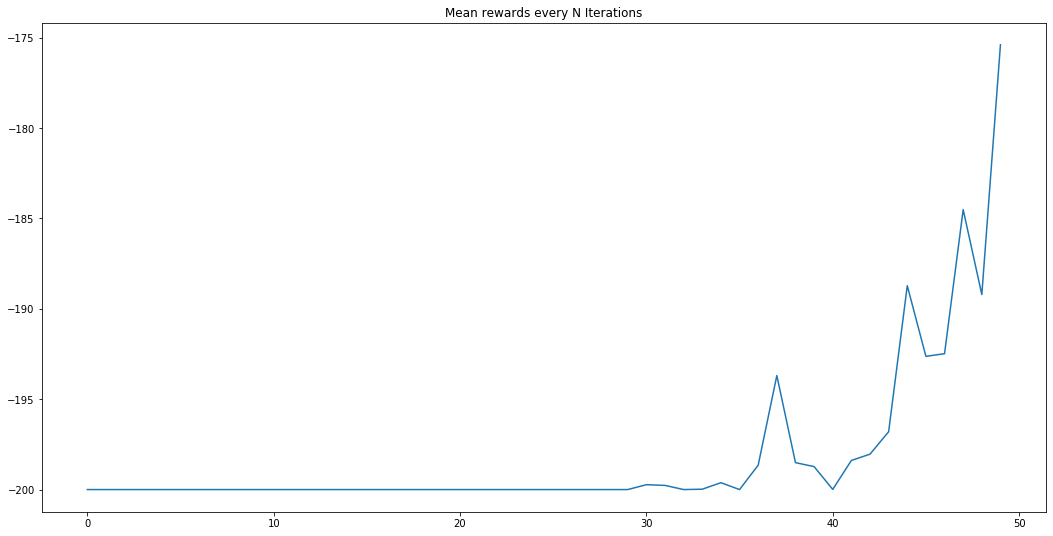

In [18]:
plt.figure(figsize=(18,9))
plt.plot(mean_rewards)
plt.title("Mean rewards every N Iterations");

## Replay a policy

In [21]:
import time

In [23]:
time.sleep(0.1)

In [ ]:
Q = q_history[100]

done = False

obs = env.reset()

while not done:

    # Choose an action greedily
    action = choose_action_greedy(q_table, discretize_state(obs, env), env)

    obs, reward, done, info = env.step(action)
    
    env.render()